<a href="https://colab.research.google.com/github/hmorgancooper/House_Price_Prediction/blob/master/NN_HousePricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```
# Prediction of house sales in King County USA using a Neural Network
Data from Kaggle: https://www.kaggle.com/harlfoxem/housesalesprediction 

#Feature Columns
- id - Unique ID for each home sold
- date - Date of the home sale
- price - Price of each home sold
- bedrooms - Number of bedrooms
- bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower
- sqft_living - Square footage of the apartments interior living space
- sqft_lot - Square footage of the land space
- floors - Number of floors
- waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not
- view - An index from 0 to 4 of how good the view of the property was
- condition - An index from 1 to 5 on the condition of the apartment,
- grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.
- sqft_above - The square footage of the interior housing space that is above ground level
- sqft_basement - The square footage of the interior housing space that is below ground level
- yr_built - The year the house was initially built
- yr_renovated - The year of the house’s last renovation
- zipcode - What zipcode area the house is in
- lat - Lattitude
- long - Longitude
- sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors
- sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors



Import libraries and upload data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Load file from computer
from google.colab import files
uploaded = files.upload()

Saving kc_house_data.csv to kc_house_data.csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['kc_house_data.csv']))

# Data Exploration and Visualisation 

In [ ]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [ ]:
df.shape

(21597, 21)

Checking for null values and duplicates

In [ ]:
print("Number of null values is \n{}".format(df.isnull().sum()))

Number of null values is 
id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


In [ ]:
print("Number of duplicates is {}".format(df.duplicated().sum()))

Number of duplicates is 0


Checking distribution of price

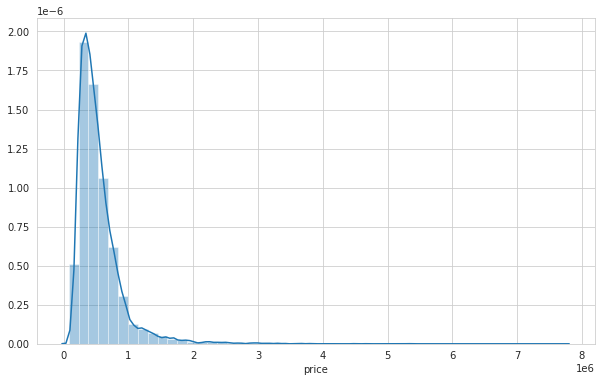

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize = (10,6))
sns.distplot(df['price'])

Most houses cost below \$2 million, so to make the model more accurate for the bulk of the data entries above \$2 million will be removed.  

In [ ]:
df2 = df[df['price']<2000000]

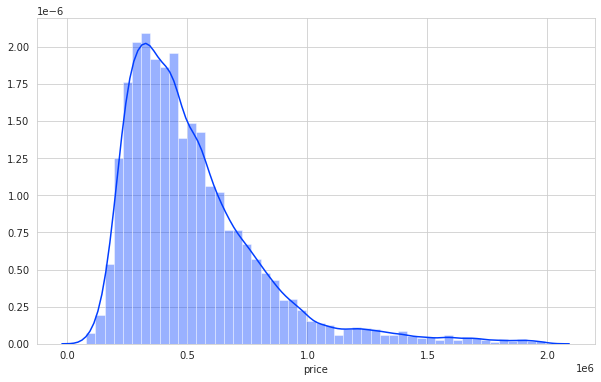

In [ ]:
plt.figure(figsize = (10,6))
sns.distplot(df2['price'])

Checking distribution of other features to catch potential outliers or mistakes. Not including ID, as information not useful, or zipcode as area info included in lat/long and zipcode will be viewed as continuous rather than categorical. Date will be converted to datetime object and then split into 'month' and 'year'.

In [ ]:
df2['date'] = pd.to_datetime(df2['date'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df2['date']

0       2014-10-13
1       2014-12-09
2       2015-02-25
3       2014-12-09
4       2015-02-18
           ...    
21592   2014-05-21
21593   2015-02-23
21594   2014-06-23
21595   2015-01-16
21596   2014-10-15
Name: date, Length: 21389, dtype: datetime64[ns]

In [ ]:
df2['year'] = df2['date'].apply(lambda x: x.year)
df2['month'] = df2['date'].apply(lambda x:x.month)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Now the useful information from date (month/year) has been extracted, deleting date column.

In [ ]:
df2 = df2.drop('date', axis = 1)

Text(0.5, 1.0, 'Distribution of Data')

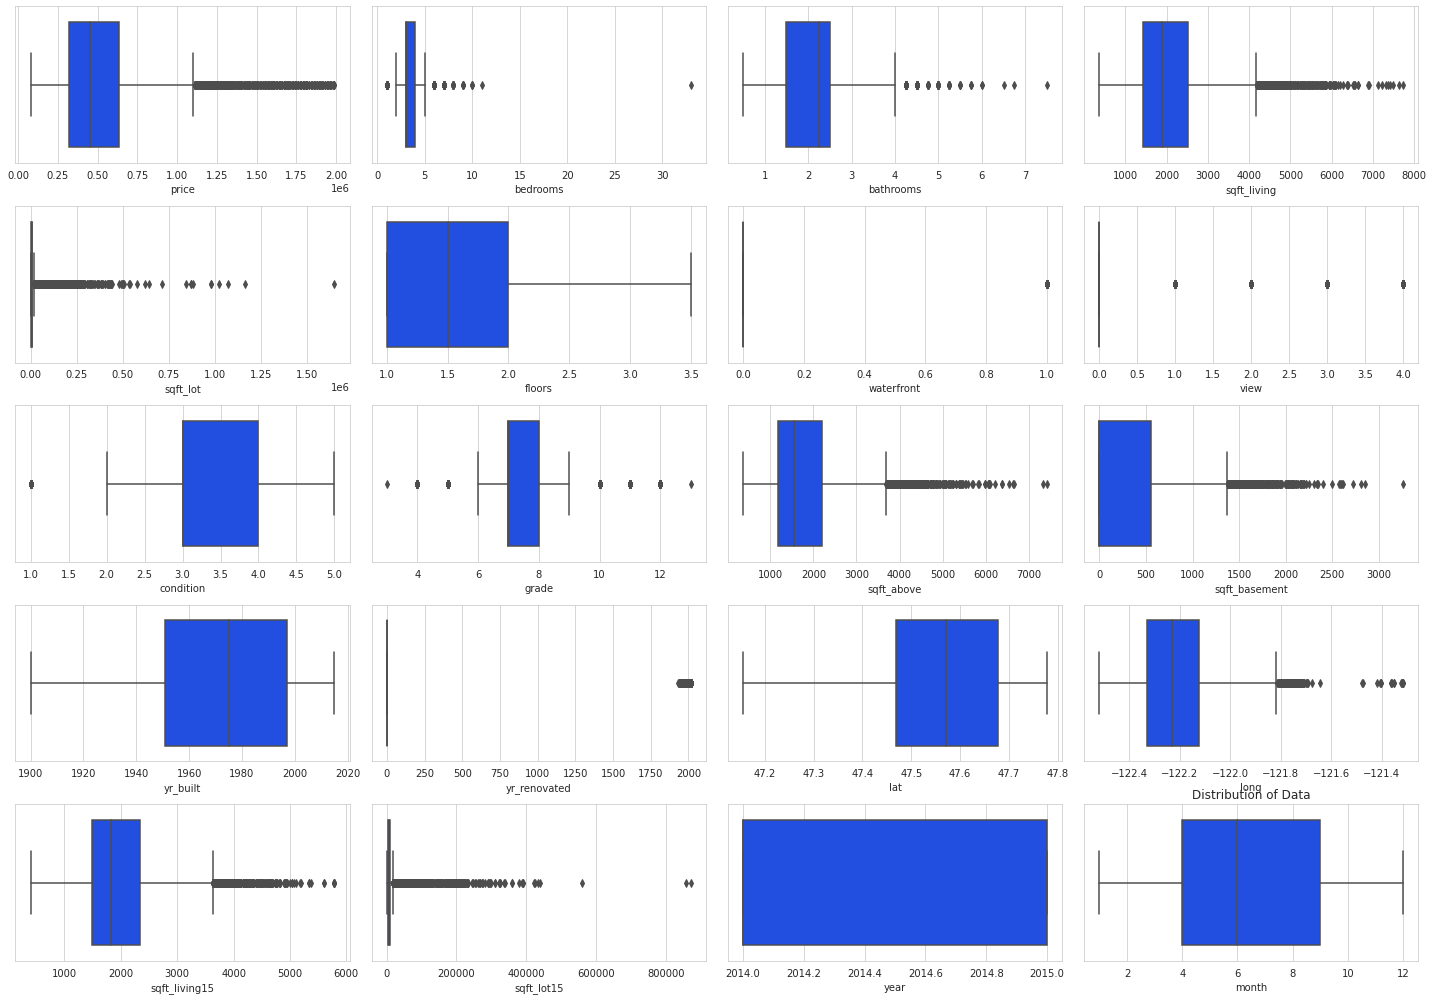

In [ ]:
fig, axes = plt.subplots(nrows = 5, ncols = 4, figsize = (20, 14))
cols_to_plot = df2.columns.drop(['id', 'zipcode'])
for i, col in enumerate(cols_to_plot):
  sns.boxplot(df2[col], ax = axes[i//4, i%4])
plt.tight_layout()
plt.title("Distribution of Data")

Most of the features look like they have a reasonable/feasible spread of data. 
- There is one extreme outlier for number of bedrooms, this point may be a mistake, but even if it is not it is so extreme it can be removed. 


In [ ]:
df2[df2['bedrooms']>30]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month
15856,2402100895,640000.0,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700,2014,6


In [ ]:
df3 = df2.drop(index = 15856)

In [ ]:
df3['bedrooms'].max()

11

Next dropping the id column as this does not contain useful information

In [ ]:
df3 = df3.drop('id', axis = 1)

Dropping zipcode column as information included better in lat and long.

In [ ]:
df3 = df3.drop('zipcode', axis = 1)

Looking at the correlation between price and the features

In [ ]:
abs(df3.corr()['price'].sort_values(ascending = False))

price            1.000000
grade            0.680899
sqft_living      0.679507
sqft_living15    0.601547
sqft_above       0.584407
bathrooms        0.508484
lat              0.363526
view             0.344283
bedrooms         0.324073
sqft_basement    0.285640
floors           0.278663
waterfront       0.142754
yr_renovated     0.118753
sqft_lot         0.098018
sqft_lot15       0.088034
yr_built         0.063393
long             0.041255
condition        0.037267
year             0.005197
month            0.014652
Name: price, dtype: float64

The size of the house (Sqft living, sqft_living15, sqft_above), grade and number of bathrooms have the largest correlation with the price. 

Text(0.5, 1.0, 'Scatterplot of house size data against price')

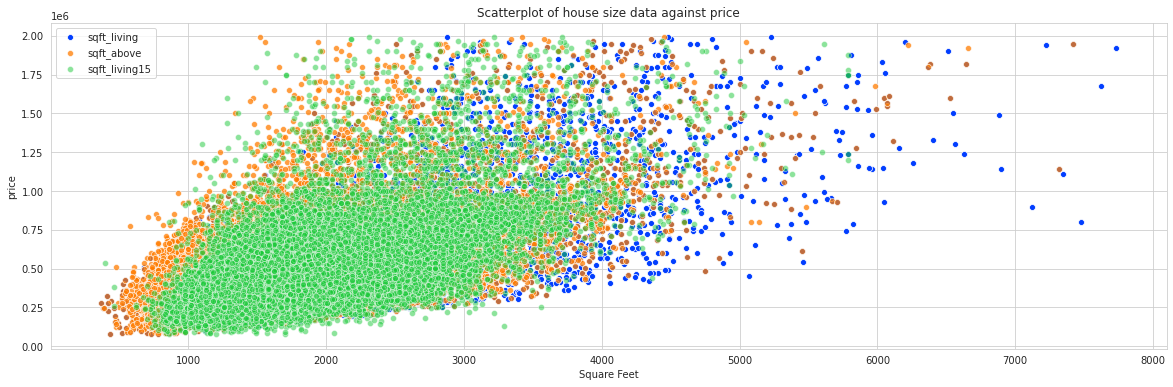

In [ ]:
plt.figure(figsize = (20,6))
sns.set_palette('bright')
sns.scatterplot(data = df3, x = 'sqft_living', y = 'price', label = 'sqft_living')
sns.scatterplot(data = df3, x = 'sqft_above', y = 'price', alpha = 0.75, label = 'sqft_above')
sns.scatterplot(data = df3, x = 'sqft_living15', y = 'price', alpha = 0.5, label = 'sqft_living15')
plt.legend()
plt.xlabel('Square Feet')
plt.title('Scatterplot of house size data against price')

Text(0.5, 1.0, 'Price distribution with grade')

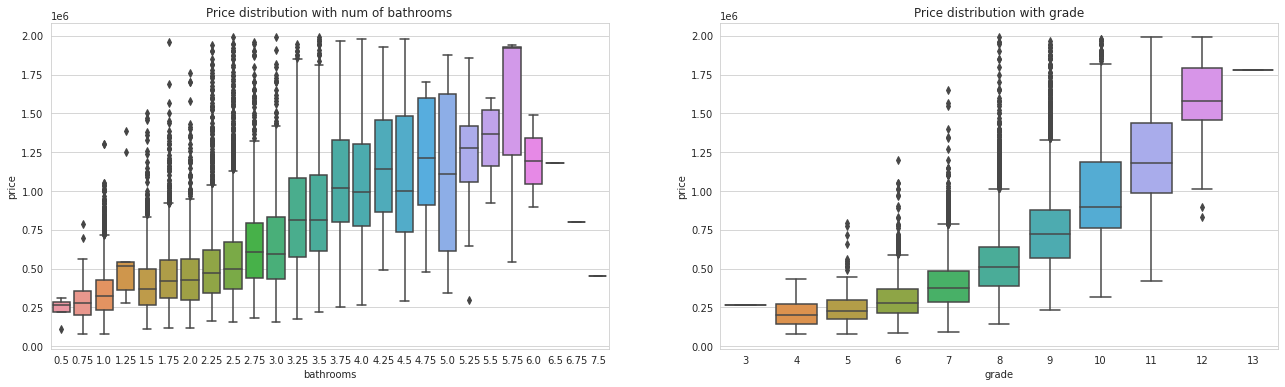

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (22,6))
sns.boxplot(data = df3, x = 'bathrooms', y = 'price', ax = ax1)
ax1.set_title("Price distribution with num of bathrooms")
sns.boxplot(data = df3, x = 'grade', y = 'price', ax = ax2)
ax2.set_title("Price distribution with grade")

With both these boxplots there is a clear correlation between price and the feature, however it is important to note that there is a lot of price variation within each feature. This is especially prevalent with the bathrooms.

Next the longitude and latitude will be plotted, with hue from the house price to identify expensive areas.

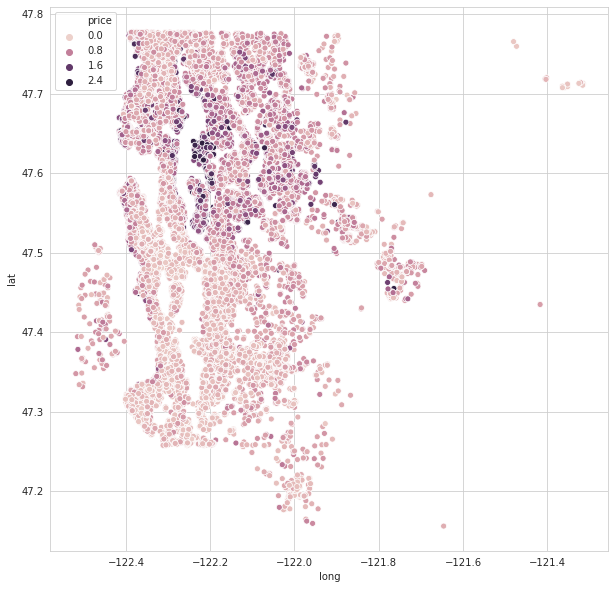

In [ ]:
plt.figure(figsize = (10, 10))
sns.scatterplot(data = df3, x = 'long', y = 'lat', hue = 'price')

# Creating the model

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df3.drop('price', axis = 1).values
y = df3['price'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

In [ ]:
X_train

array([[4.000e+00, 1.000e+00, 1.670e+03, ..., 4.600e+03, 2.014e+03,
        9.000e+00],
       [4.000e+00, 2.500e+00, 2.990e+03, ..., 7.401e+03, 2.014e+03,
        9.000e+00],
       [3.000e+00, 1.000e+00, 1.570e+03, ..., 9.100e+03, 2.014e+03,
        5.000e+00],
       ...,
       [2.000e+00, 1.000e+00, 9.400e+02, ..., 6.000e+03, 2.014e+03,
        7.000e+00],
       [4.000e+00, 2.500e+00, 2.770e+03, ..., 9.219e+03, 2.014e+03,
        7.000e+00],
       [4.000e+00, 1.500e+00, 2.700e+03, ..., 7.200e+03, 2.014e+03,
        1.100e+01]])

Scaling the data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()



In [ ]:
scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
X_train = scaler.transform(X_train)

In [ ]:
X_train

array([[0.3       , 0.08      , 0.18284107, ..., 0.00460535, 0.        ,
        0.72727273],
       [0.3       , 0.32      , 0.36849508, ..., 0.00787189, 0.        ,
        0.72727273],
       [0.2       , 0.08      , 0.16877637, ..., 0.00985328, 0.        ,
        0.36363636],
       ...,
       [0.1       , 0.08      , 0.08016878, ..., 0.00623804, 0.        ,
        0.54545455],
       [0.3       , 0.32      , 0.33755274, ..., 0.00999206, 0.        ,
        0.54545455],
       [0.3       , 0.16      , 0.32770745, ..., 0.00763749, 0.        ,
        0.90909091]])

In [ ]:
X_test = scaler.transform(X_test)

In [ ]:
X_test

array([[2.00000000e-01, 2.00000000e-01, 2.20815752e-01, ...,
        9.92908298e-03, 1.00000000e+00, 1.81818182e-01],
       [3.00000000e-01, 4.80000000e-01, 5.00703235e-01, ...,
        6.02345708e-03, 0.00000000e+00, 3.63636364e-01],
       [3.00000000e-01, 2.80000000e-01, 1.95499297e-01, ...,
        1.05016904e-02, 0.00000000e+00, 4.54545455e-01],
       ...,
       [2.00000000e-01, 2.40000000e-01, 1.95499297e-01, ...,
        1.09716717e-02, 1.00000000e+00, 0.00000000e+00],
       [3.00000000e-01, 3.20000000e-01, 2.96765120e-01, ...,
        5.07183250e-03, 0.00000000e+00, 8.18181818e-01],
       [1.00000000e-01, 3.20000000e-01, 8.57946554e-02, ...,
        4.33828855e-04, 0.00000000e+00, 8.18181818e-01]])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
model = Sequential()

In [ ]:
X_train.shape

(14329, 19)

X_train has 19 features so will start with 19 neurons.

In [ ]:
model.add(Dense(19, activation = 'relu'))
model.add(Dense(19, activation = 'relu'))
model.add(Dense(19, activation = 'relu'))
model.add(Dense(19, activation = 'relu'))
model.add(Dense(19, activation = 'relu'))

model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
model.fit(x = X_train,y =  y_train, validation_data= (X_test, y_test), batch_size= 128, epochs = 400)

Epoch 1/400
112/112 [==============================] - 0s 3ms/step - loss: 349537173504.0000 - val_loss: 354145107968.0000
Epoch 2/400
112/112 [==============================] - 0s 2ms/step - loss: 339618267136.0000 - val_loss: 314690895872.0000
Epoch 3/400
112/112 [==============================] - 0s 2ms/step - loss: 188529983488.0000 - val_loss: 64652808192.0000
Epoch 4/400
112/112 [==============================] - 0s 2ms/step - loss: 54418395136.0000 - val_loss: 56347906048.0000
Epoch 5/400
112/112 [==============================] - 0s 3ms/step - loss: 52356825088.0000 - val_loss: 54608281600.0000
Epoch 6/400
112/112 [==============================] - 0s 3ms/step - loss: 50687639552.0000 - val_loss: 52891611136.0000
Epoch 7/400
112/112 [==============================] - 0s 2ms/step - loss: 49013190656.0000 - val_loss: 51156815872.0000
Epoch 8/400
112/112 [==============================] - 0s 2ms/step - loss: 47348854784.0000 - val_loss: 49381629952.0000
Epoch 9/400
112/112 [======

Assessing model

In [ ]:
losses = pd.DataFrame(model.history.history)

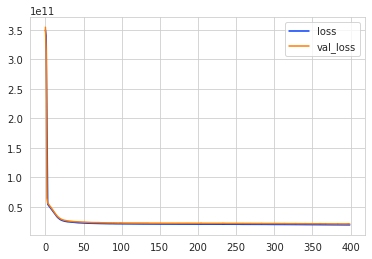

In [ ]:
losses.plot()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
pred = model.predict(X_test)

In [ ]:
print("MAE:", mean_absolute_error(y_test, pred))
print("MSE:", mean_squared_error(y_test, pred))
print("RMSE:", mean_squared_error(y_test, pred)**0.5)
print("Percentage MAE: {:.4}%".format(mean_absolute_error(y_test, pred)/df3['price'].mean() *100 ))

MAE: 96433.79648265954
MSE: 20915832796.964153
RMSE: 144623.07145460628
Percentage MAE: 18.58%


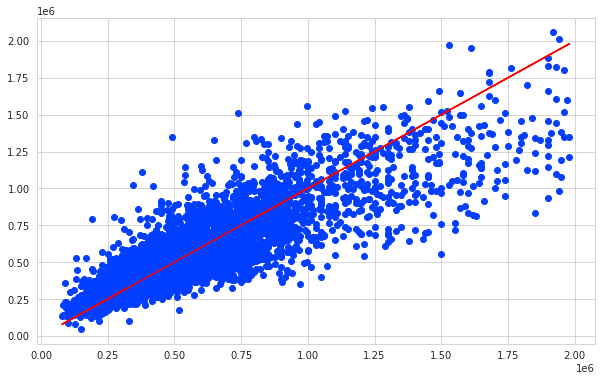

In [ ]:
plt.figure(figsize = (10,6))
plt.scatter(y_test, pred)
plt.plot(y_test, y_test, 'r')